In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.preprocessing import StandardScaler

In [6]:
def detect_vendor_invoice_anomalies_hierarchical(df, 
                                                 invoice_column='fldInvoiceAmount', 
                                                 vendor_column='fldVendorNo', 
                                                 min_cluster_size=2, 
                                                 distance_threshold=2.5):
    """
    Detect invoice amount anomalies for each vendor using hierarchical clustering
    
    Parameters:
    - df: Input DataFrame
    - invoice_column: Column containing invoice amounts
    - vendor_column: Column containing vendor identifiers
    - min_cluster_size: Minimum cluster size to consider normal
    - distance_threshold: Clustering distance threshold
    
    Returns:
    - DataFrame with anomaly annotations
    - Summary of vendor anomalies
    """
    # Create a copy of the DataFrame
    result_df = df.copy()
    
    # Prepare to store vendor-specific anomaly information
    vendor_anomaly_summary = []
    
    # Process each unique vendor
    def process_vendor_anomalies(vendor_data):
        # Skip vendors with insufficient data
        if len(vendor_data) < 3:
            return vendor_data.assign(
                Vendor_InvoiceAmount_Anomaly='Insufficient Data',
                Cluster=np.nan
            )
        
        # Scale invoice amounts
        scaler = StandardScaler()
        scaled_invoices = scaler.fit_transform(vendor_data[[invoice_column]])
        
        try:
            # Perform hierarchical clustering
            Z = linkage(scaled_invoices, method='ward')
            
            # Assign clusters
            clusters = fcluster(Z, t=distance_threshold, criterion='distance')
            vendor_data['Cluster'] = clusters
            
            # Count cluster sizes
            cluster_sizes = pd.Series(clusters).value_counts()
            
            # Identify small clusters as anomalies
            anomaly_clusters = cluster_sizes[cluster_sizes < min_cluster_size].index
            
            # Mark anomalies
            vendor_data['Vendor_InvoiceAmount_Anomaly'] = vendor_data['Cluster'].apply(
                lambda x: 'Yes' if x in anomaly_clusters else 'No'
            )
            
            # Prepare vendor summary
            anomaly_count = (vendor_data['Vendor_InvoiceAmount_Anomaly'] == 'Yes').sum()
            vendor_summary = {
                'VendorNo': vendor_data[vendor_column].iloc[0],
                'TotalTransactions': len(vendor_data),
                'AnomalyCount': anomaly_count,
                'AnomalyPercentage': (anomaly_count / len(vendor_data)) * 100,
                'MeanInvoiceAmount': vendor_data[invoice_column].mean(),
                'StdInvoiceAmount': vendor_data[invoice_column].std()
            }
            vendor_anomaly_summary.append(vendor_summary)
            
            return vendor_data
        
        except Exception as e:
            print(f"Error processing vendor {vendor_data[vendor_column].iloc[0]}: {e}")
            return vendor_data.assign(
                Vendor_InvoiceAmount_Anomaly='Processing Error',
                Cluster=np.nan
            )
    
    # Apply vendor-specific anomaly detection
    result_df = result_df.groupby(vendor_column).apply(process_vendor_anomalies).reset_index(drop=True)
    
    # Create vendor anomaly summary DataFrame
    vendor_summary_df = pd.DataFrame(vendor_anomaly_summary)
    
    # Visualization of anomalies
    plt.figure(figsize=(15, 6))
    sns.scatterplot(
        data=result_df, 
        x=vendor_column, 
        y=invoice_column, 
        hue='Vendor_InvoiceAmount_Anomaly',
        palette={'Yes': 'red', 'No': 'green', 'Insufficient Data': 'gray', 'Processing Error': 'orange'}
    )
    plt.title("Vendor-Specific Invoice Amount Anomalies")
    plt.xlabel("Vendor Number")
    plt.ylabel("Invoice Amount")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    return result_df, vendor_summary_df

In [7]:
def main():
    # Load the dataset
    df = pd.read_csv("output_with_anomalies.csv")
    
    # Detect vendor-specific invoice amount anomalies
    df_with_anomalies, vendor_summary = detect_vendor_invoice_anomalies_hierarchical(
        df, 
        min_cluster_size=2,  # Minimum cluster size to consider normal
        distance_threshold=1.5  # Clustering distance threshold
    )
    
    # Save results
    df_with_anomalies.to_csv("vendor_specific_hierarchical_anomalies.csv", index=False)
    vendor_summary.to_csv("vendor_hierarchical_anomaly_summary.csv", index=False)
    
    # Print summary for analysis
    print("Vendor Anomaly Summary:")
    print(vendor_summary)
    
    # Additional visualization of anomaly percentages
    plt.figure(figsize=(12, 6))
    vendor_summary.sort_values('AnomalyPercentage', ascending=False).plot(
        x='VendorNo', 
        y='AnomalyPercentage', 
        kind='bar'
    )
    plt.title("Percentage of Anomalous Invoices by Vendor")
    plt.xlabel("Vendor Number")
    plt.ylabel("Anomaly Percentage")
    plt.tight_layout()
    plt.show()

C:\Users\Dhireen Kumar Rajak\AppData\Local\Temp\ipykernel_10836\1906908801.py:80: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result_df = result_df.groupby(vendor_column).apply(process_vendor_anomalies).reset_index(drop=True)


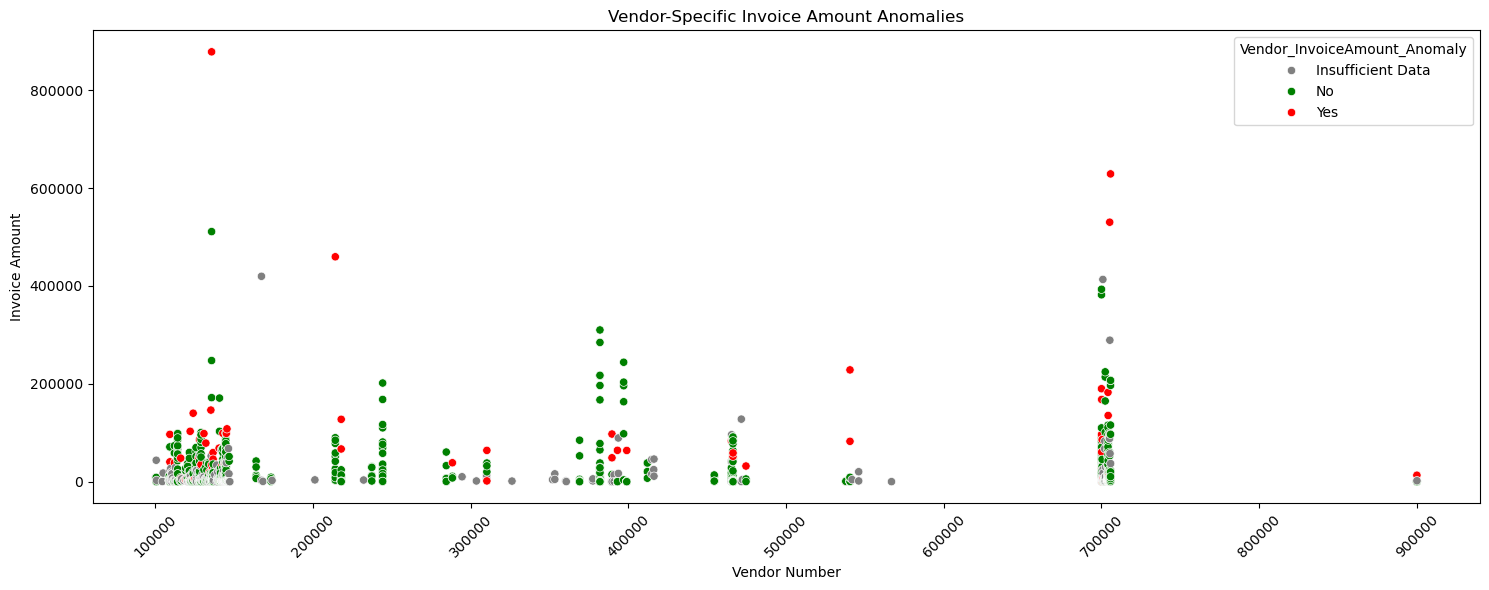

Vendor Anomaly Summary:
     VendorNo  TotalTransactions  AnomalyCount  AnomalyPercentage  \
0      100730                  4             0           0.000000   
1      109029                 12             0           0.000000   
2      109371                185             2           1.081081   
3      112224                 22             1           4.545455   
4      114316                331             0           0.000000   
..        ...                ...           ...                ...   
108    705002                  3             1          33.333333   
109    705016                253             0           0.000000   
110    705236                  9             1          11.111111   
111    705770                 15             1           6.666667   
112    900000                  5             1          20.000000   

     MeanInvoiceAmount  StdInvoiceAmount  
0          4143.712500       4584.771537  
1          4662.910833       4269.830367  
2          2180.65

<Figure size 1200x600 with 0 Axes>

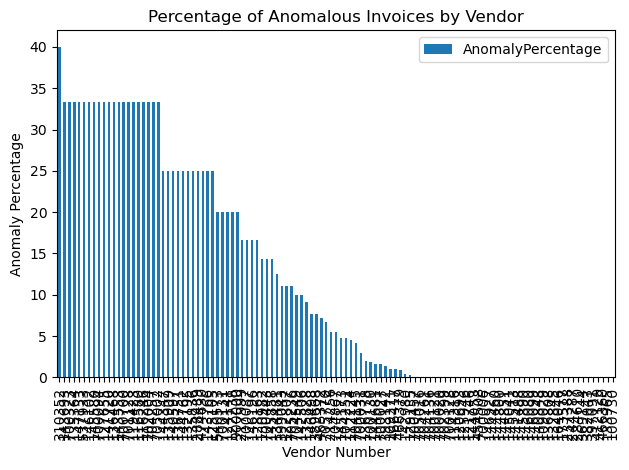

In [9]:
if __name__ == "__main__":
    main()